In [1]:
import os
import glob
import json
import shutil
import h5py
import sys
import time
from IPython.display import display

import torch

sys.path.insert(0, '..')
from corr_methods import load_representations

## Compute neuron/layer similarities based on activations
Using first N token representations from WSJ POS tagging sentences.

Saves to files in ../results/LTH-base/

In [191]:
# Set arguments to load reps
limit = 10000
model_count = 8
reps_dir = '/raj-learn/data/precomputed_reps'
rep_fname_l = sorted(glob.glob(f'{reps_dir}/LTH*/syntactic_constituency.hdf5'))
layerspec_l = ['all' for i in range(len(rep_fname_l))]
first_half_only_l = False
second_half_only_l = False
device = 'cuda'
rep_fname_l

['/raj-learn/data/precomputed_reps/LTH0/syntactic_constituency.hdf5',
 '/raj-learn/data/precomputed_reps/LTH1/syntactic_constituency.hdf5',
 '/raj-learn/data/precomputed_reps/LTH2/syntactic_constituency.hdf5',
 '/raj-learn/data/precomputed_reps/LTH3/syntactic_constituency.hdf5',
 '/raj-learn/data/precomputed_reps/LTH4/syntactic_constituency.hdf5',
 '/raj-learn/data/precomputed_reps/LTH5/syntactic_constituency.hdf5',
 '/raj-learn/data/precomputed_reps/LTH6/syntactic_constituency.hdf5',
 '/raj-learn/data/precomputed_reps/LTH7/syntactic_constituency.hdf5']

In [3]:
%%time
num_neurons_d, representations_d = load_representations(rep_fname_l,
                                                        limit=limit, 
                                                        layerspec_l=layerspec_l, 
                                                        first_half_only_l=first_half_only_l,
                                                        second_half_only_l=second_half_only_l)

8it [20:22, 152.82s/it]

CPU times: user 1min 13s, sys: 2.63 s, total: 1min 16s
Wall time: 20min 22s


In [4]:
import importlib

import corr_methods
importlib.reload(corr_methods)

from corr_methods import MaxCorr, MinCorr, MaxLinReg, MinLinReg, CCA, LinCKA

In [5]:
%%time
maxcorr = corr_methods.MaxCorr(num_neurons_d, None, device)
mincorr = corr_methods.MinCorr(num_neurons_d, None, device)
maxlinreg = corr_methods.MaxLinReg(num_neurons_d, None, device)
minlinreg = corr_methods.MinLinReg(num_neurons_d, None, device)
cca = corr_methods.CCA(num_neurons_d, None, device)
lincka = corr_methods.LinCKA(num_neurons_d, None, device)

CPU times: user 62 µs, sys: 4 µs, total: 66 µs
Wall time: 77.2 µs


In [6]:
%%time
output_dir = '../results/LTH-base/'
for corr_method in [maxcorr, mincorr, maxlinreg, minlinreg, lincka]:
# for corr_method in [minlinreg, cca, lincka]:
    t0 = time.time()
    method_name = str(corr_method)
    print(method_name)
    corr_method.representations_d = representations_d.copy()
    corr_method.compute_correlations()
    corr_method.write_correlations(output_dir + method_name)
    print('%s took %.2fsec' % (method_name, time.time() - t0))

mu, sigma:   0%|          | 0/48 [00:00<?, ?it/s]

maxcorr


mu, sigma:   8%|▊         | 4/48 [00:00<00:01, 27.80it/s]

maxcorr took 73.63sec
mincorr


mu, sigma:   0%|          | 0/48 [00:00<?, ?it/s]

mincorr took 58.91sec
maxlinreg


mu, sigma:   0%|          | 0/48 [00:00<?, ?it/s]

maxlinreg took 115.52sec
minlinreg


mu, sigma:   4%|▍         | 2/48 [00:00<00:03, 13.05it/s]

minlinreg took 115.05sec
lincka


lincka: 100%|██████████| 2304/2304 [00:20<00:00, 114.54it/s]


lincka took 25.72sec
CPU times: user 22min 23s, sys: 4min 56s, total: 27min 19s
Wall time: 6min 28s


## Analyze neuron-level similarity between layers
We first consider 'neuronsim', a measure of local representation similarity of two layers. This metric is computed as follows: for each neuron in layer L, compute max correlation with any neuron in layer L'. Then, the similarity between L and L' is given by the mean of all those max correlations. MaxCorr or MinCorr refers to whether we consider the most "important" neurons for a given layer as the ones that have the highest maximal correlation with neurons in any other layer or ones that have the highest minimal correlation with neurons in any other layer.

We next consider 'mixedsim', a measure of how a local representation in layer L is predicted by the overall representation of layer L'. In particular, we regress Y, the output of a neuron in L, as a linear function of X, the full-dim representation output of layer L' (regression learned from each of the tokens we have a representation for). The correlation of our regression to Y is the similarity metric. We then average this metric across all neurons in layer L.

In [7]:
%%time
import pickle

results_dir = '../results/LTH-base/'
res_fname = {method : results_dir + method for method in 
                {"maxcorr", "mincorr", "maxlinreg", "minlinreg", "cca", "lincka"}}

res_dict = {}
res_dict["maxcorr"] = pickle.load(open(res_fname["maxcorr"], "rb"))
res_dict["mincorr"] = pickle.load(open(res_fname["mincorr"], "rb"))
res_dict["maxlinreg"] = pickle.load(open(res_fname["maxlinreg"], "rb"))
res_dict["minlinreg"] = pickle.load(open(res_fname["minlinreg"], "rb"))

In [53]:
layer_names = list(res_dict['maxcorr']['corrs'].keys())
num_neurons = len(res_dict['maxcorr']['neuron_sort'][layer_names[0]])

In [24]:
print(res_dict['maxcorr'].keys())
print(res_dict['maxlinreg'].keys())

dict_keys(['corrs', 'pairs', 'similarities', 'neuron_sort', 'neuron_notated_sort'])
dict_keys(['pred_power', 'similarities', 'neuron_sort', 'neuron_notated_sort'])


Do neurons retain behavior as sparsity increases? We can estimate this question by computing the number of neurons in layer L, pruning iteration 0 that have highest correlation with the same neuron at a later pruning iteration P. Then, we can compute the same fraction with the top K (perhaps K=128) neurons; i.e., for the K pairs of neurons with highest correlation between pruning iteration 0 and P, how many of the pairs are the same neuron?

For the first analysis, we can simply count the number of matches between range(num_neurons) and res_dict['maxcorr']['pairs'][LTH-0 layer L][LTH-P layer L]. For the second analysis, we need to first argsort the MaxCorrs between layer L at pruning iter 0 vs P, stored in res_dict['maxcorr']['corrs']. Then, we check to see if the top K argsorted indices have matching paired indices, by comparing against res_dict['maxcorr']['pairs'].

In [70]:
import numpy as np

layers = list(range(6))
matched_neurons = {layer : [num_neurons] for layer in layers}
K = 256
topK_matched_neurons = {layer : [K] for layer in layers}
for layer in layers:
    pairs = res_dict['maxcorr']['pairs'][f'LTH0-syntactic_constituency.hdf5_{layer}']
    corrs = res_dict['maxcorr']['corrs'][f'LTH0-syntactic_constituency.hdf5_{layer}']
    for lth_iter in range(1, model_count):
        name = f'LTH{lth_iter}-syntactic_constituency.hdf5_{layer}'
        matches = (np.arange(num_neurons) == pairs[name])
        matched_neurons[layer].append(matches.sum())
        
        topK_idxs = np.argsort(corrs[name])[-K : ]
        topK_matched_neurons[layer].append(matches[topK_idxs].sum())
        
display(matched_neurons)
display(topK_matched_neurons)

{0: [1024, 1024, 1024, 1024, 1023, 1022, 1022, 1021],
 1: [1024, 1024, 1024, 1024, 1024, 1024, 1023, 1022],
 2: [1024, 1024, 1024, 1024, 1024, 1024, 1023, 1023],
 3: [1024, 1024, 1024, 1023, 1023, 1023, 1022, 1021],
 4: [1024, 1024, 1024, 1023, 1023, 1023, 1023, 1022],
 5: [1024, 1024, 1024, 1024, 1024, 1023, 1023, 1022]}

{0: [256, 256, 256, 256, 256, 256, 256, 256],
 1: [256, 256, 256, 256, 256, 256, 255, 254],
 2: [256, 256, 256, 256, 256, 256, 255, 255],
 3: [256, 256, 256, 256, 256, 255, 254, 254],
 4: [256, 256, 256, 256, 256, 256, 256, 255],
 5: [256, 256, 256, 256, 256, 256, 256, 255]}

This result shows that by-and-large, a given neuron's function stays the same as sparsity increases.

We next consider how neuron activations evolve with layer at varying sparsity. The result suggests that most dimensions of a word's contextual embedding display semi-consistent behavior at each layer. However, at higher sparsities, fewer of the embedding components are retained at the last layer compared to the first layer. Sparser models' higher layers have less similar neurons to their lower layers compared to unpruned models.

In [195]:
lth_iters = list(range(8))
matched_neurons = {lth_iter : [num_neurons] for lth_iter in lth_iters}
matched_neuron_idxs = {}
K = 256
topK_matched_neurons = {lth_iter : [K] for lth_iter in lth_iters}
for lth_iter in lth_iters:
    pairs = res_dict['maxcorr']['pairs'][f'LTH{lth_iter}-syntactic_constituency.hdf5_0']
    corrs = res_dict['maxcorr']['corrs'][f'LTH{lth_iter}-syntactic_constituency.hdf5_0']
    for layer in range(1, 6):
        name = f'LTH{lth_iter}-syntactic_constituency.hdf5_{layer}'
        matches = (np.arange(num_neurons) == pairs[name])
        if layer == 5: # final layer
            matched_neuron_idxs[lth_iter] = np.arange(num_neurons)[matches]
        matched_neurons[lth_iter].append(matches.sum())
        
        topK_idxs = np.argsort(corrs[name])[-K : ]
        topK_matched_neurons[lth_iter].append(matches[topK_idxs].sum())

display(matched_neurons)
display(topK_matched_neurons)

{0: [1024, 986, 962, 914, 884, 861],
 1: [1024, 987, 959, 909, 879, 858],
 2: [1024, 985, 954, 908, 876, 849],
 3: [1024, 985, 954, 903, 860, 837],
 4: [1024, 981, 952, 891, 855, 831],
 5: [1024, 981, 941, 879, 835, 811],
 6: [1024, 976, 930, 870, 823, 795],
 7: [1024, 970, 916, 851, 813, 781]}

{0: [256, 256, 256, 255, 253, 255],
 1: [256, 256, 256, 254, 253, 255],
 2: [256, 256, 255, 254, 255, 255],
 3: [256, 256, 255, 255, 255, 255],
 4: [256, 256, 255, 255, 255, 254],
 5: [256, 256, 256, 255, 254, 254],
 6: [256, 256, 256, 256, 255, 254],
 7: [256, 256, 256, 256, 255, 255]}

### Compute variance explained by top k PCs

In [209]:
%%time
model_var_explained = {}
for lth_iter in range(model_count):
    layer = f'LTH{lth_iter}-syntactic_constituency.hdf5_5'
    X = representations_d[layer]
    U, S, V = torch.svd(X)

    var_sums = torch.cumsum(S.pow(2), 0)
    model_var_explained[f'LTH{lth_iter}'] = (var_sums / var_sums[-1])

CPU times: user 1min 45s, sys: 8.69 s, total: 1min 54s
Wall time: 14.9 s


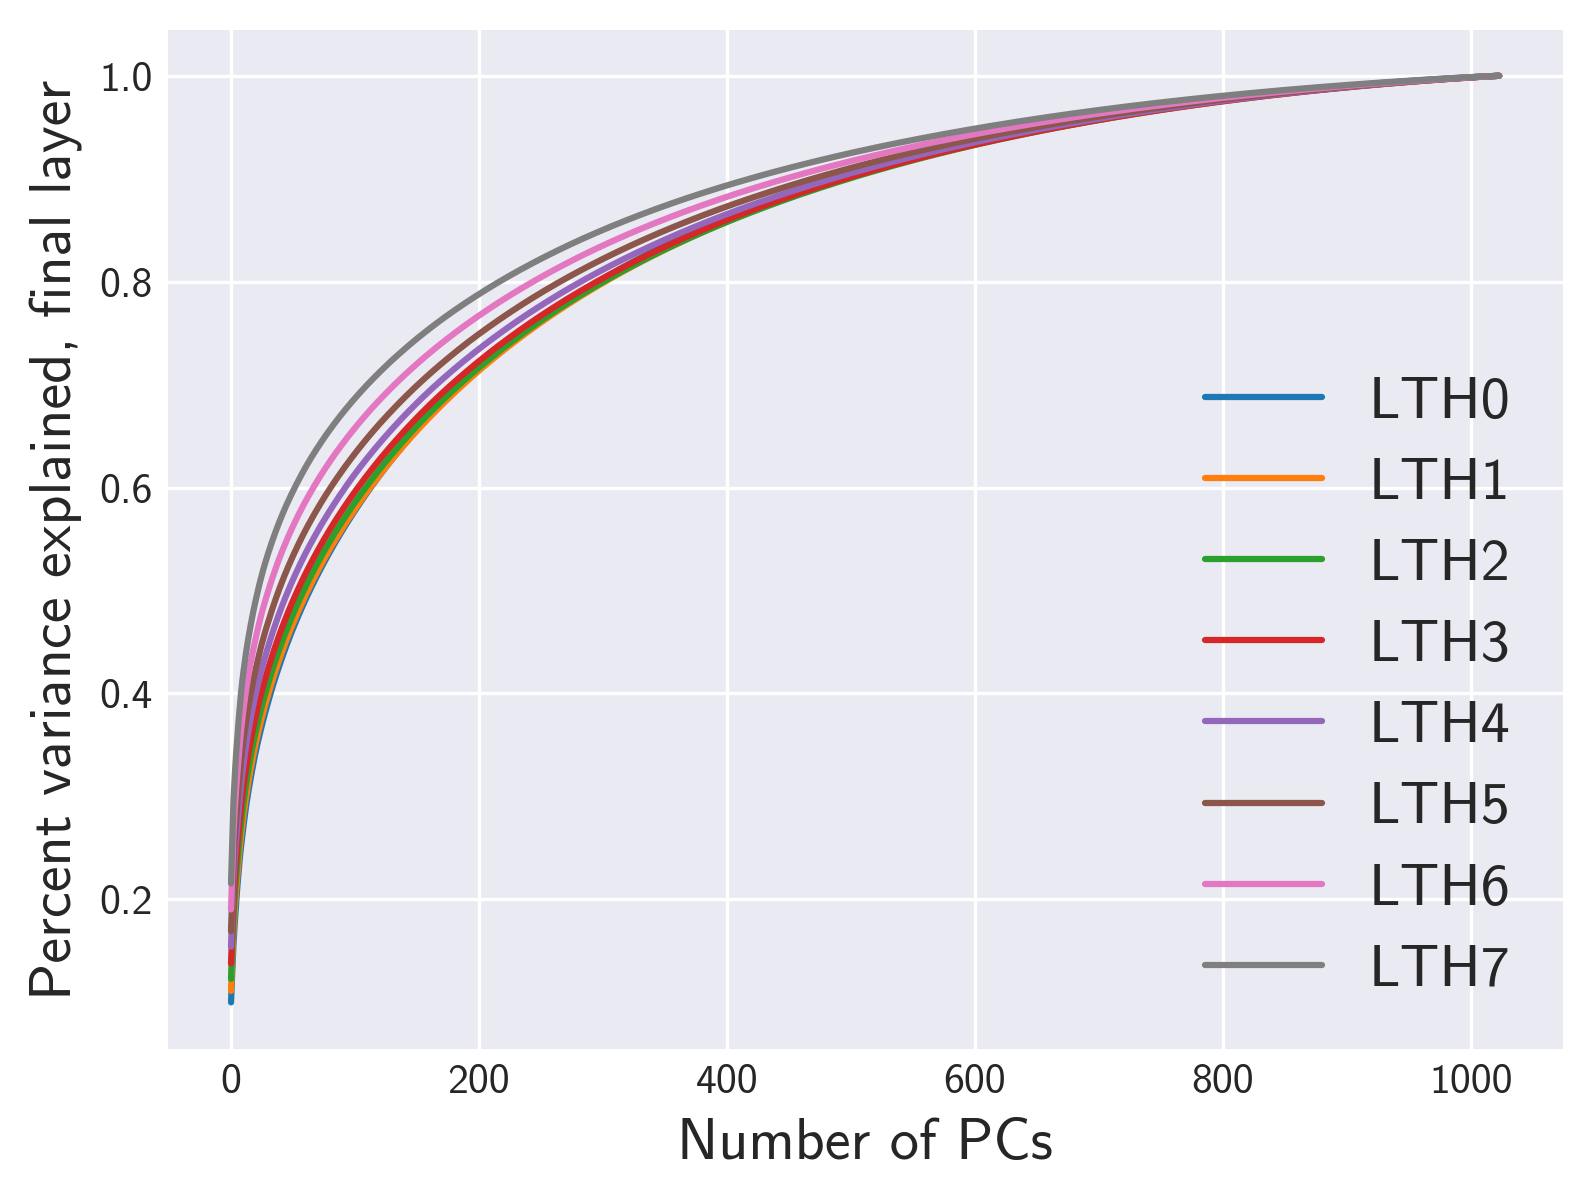

In [216]:
plt.figure(figsize = (6, 4.5), dpi=300)
ax = plt.gca()

n_components = len(model_var_explained['LTH0'])
for model in model_var_explained:
    ax.plot(np.arange(n_components), model_var_explained[model], label=model)
#     ax.scatter(x, layer_corrs_with_unpruned[layer], s=6)
    
plt.xlabel('Number of PCs', fontsize=14)
plt.ylabel('Percent variance explained, final layer', fontsize=14)
plt.legend(fontsize=14)
plt.show()

### Plot neuronsim correlation matrices

In [153]:
%%time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle
from matplotlib import rcParams
from matplotlib import font_manager
fpath = '/raj-learn/envs/contextual_repr_analysis/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf'
prop = font_manager.FontProperties(fname=fpath)
rcParams['font.family'] = prop.get_name()
rcParams['mathtext.fontset'] = 'cm'
rcParams['axes.unicode_minus'] = False

def formatFloat(fmt, val):
    ret = fmt % val
    if ret.startswith("0."):
        return ret[1:]
    if ret.startswith("-0."):
        return "-" + ret[2:]
    return ret

CPU times: user 355 µs, sys: 0 ns, total: 355 µs
Wall time: 372 µs


In [94]:
neuronsim = {'maxcorr' : {},
             'maxlinreg' : {}
            }

def fix_layername(layer):
    return layer.split('-')[0] + '-layer' + str(int(layer.split('_')[-1])+1)

for simtype in ['maxcorr', 'maxlinreg']:
    for layer in layer_names:
        neuronsim[simtype][fix_layername(layer)] = {fix_layername(layer) : 1.0}
        similarities = res_dict[simtype]['similarities'][layer]
        for other_layer in similarities:
            neuronsim[simtype][fix_layername(layer)][fix_layername(other_layer)] = similarities[other_layer]

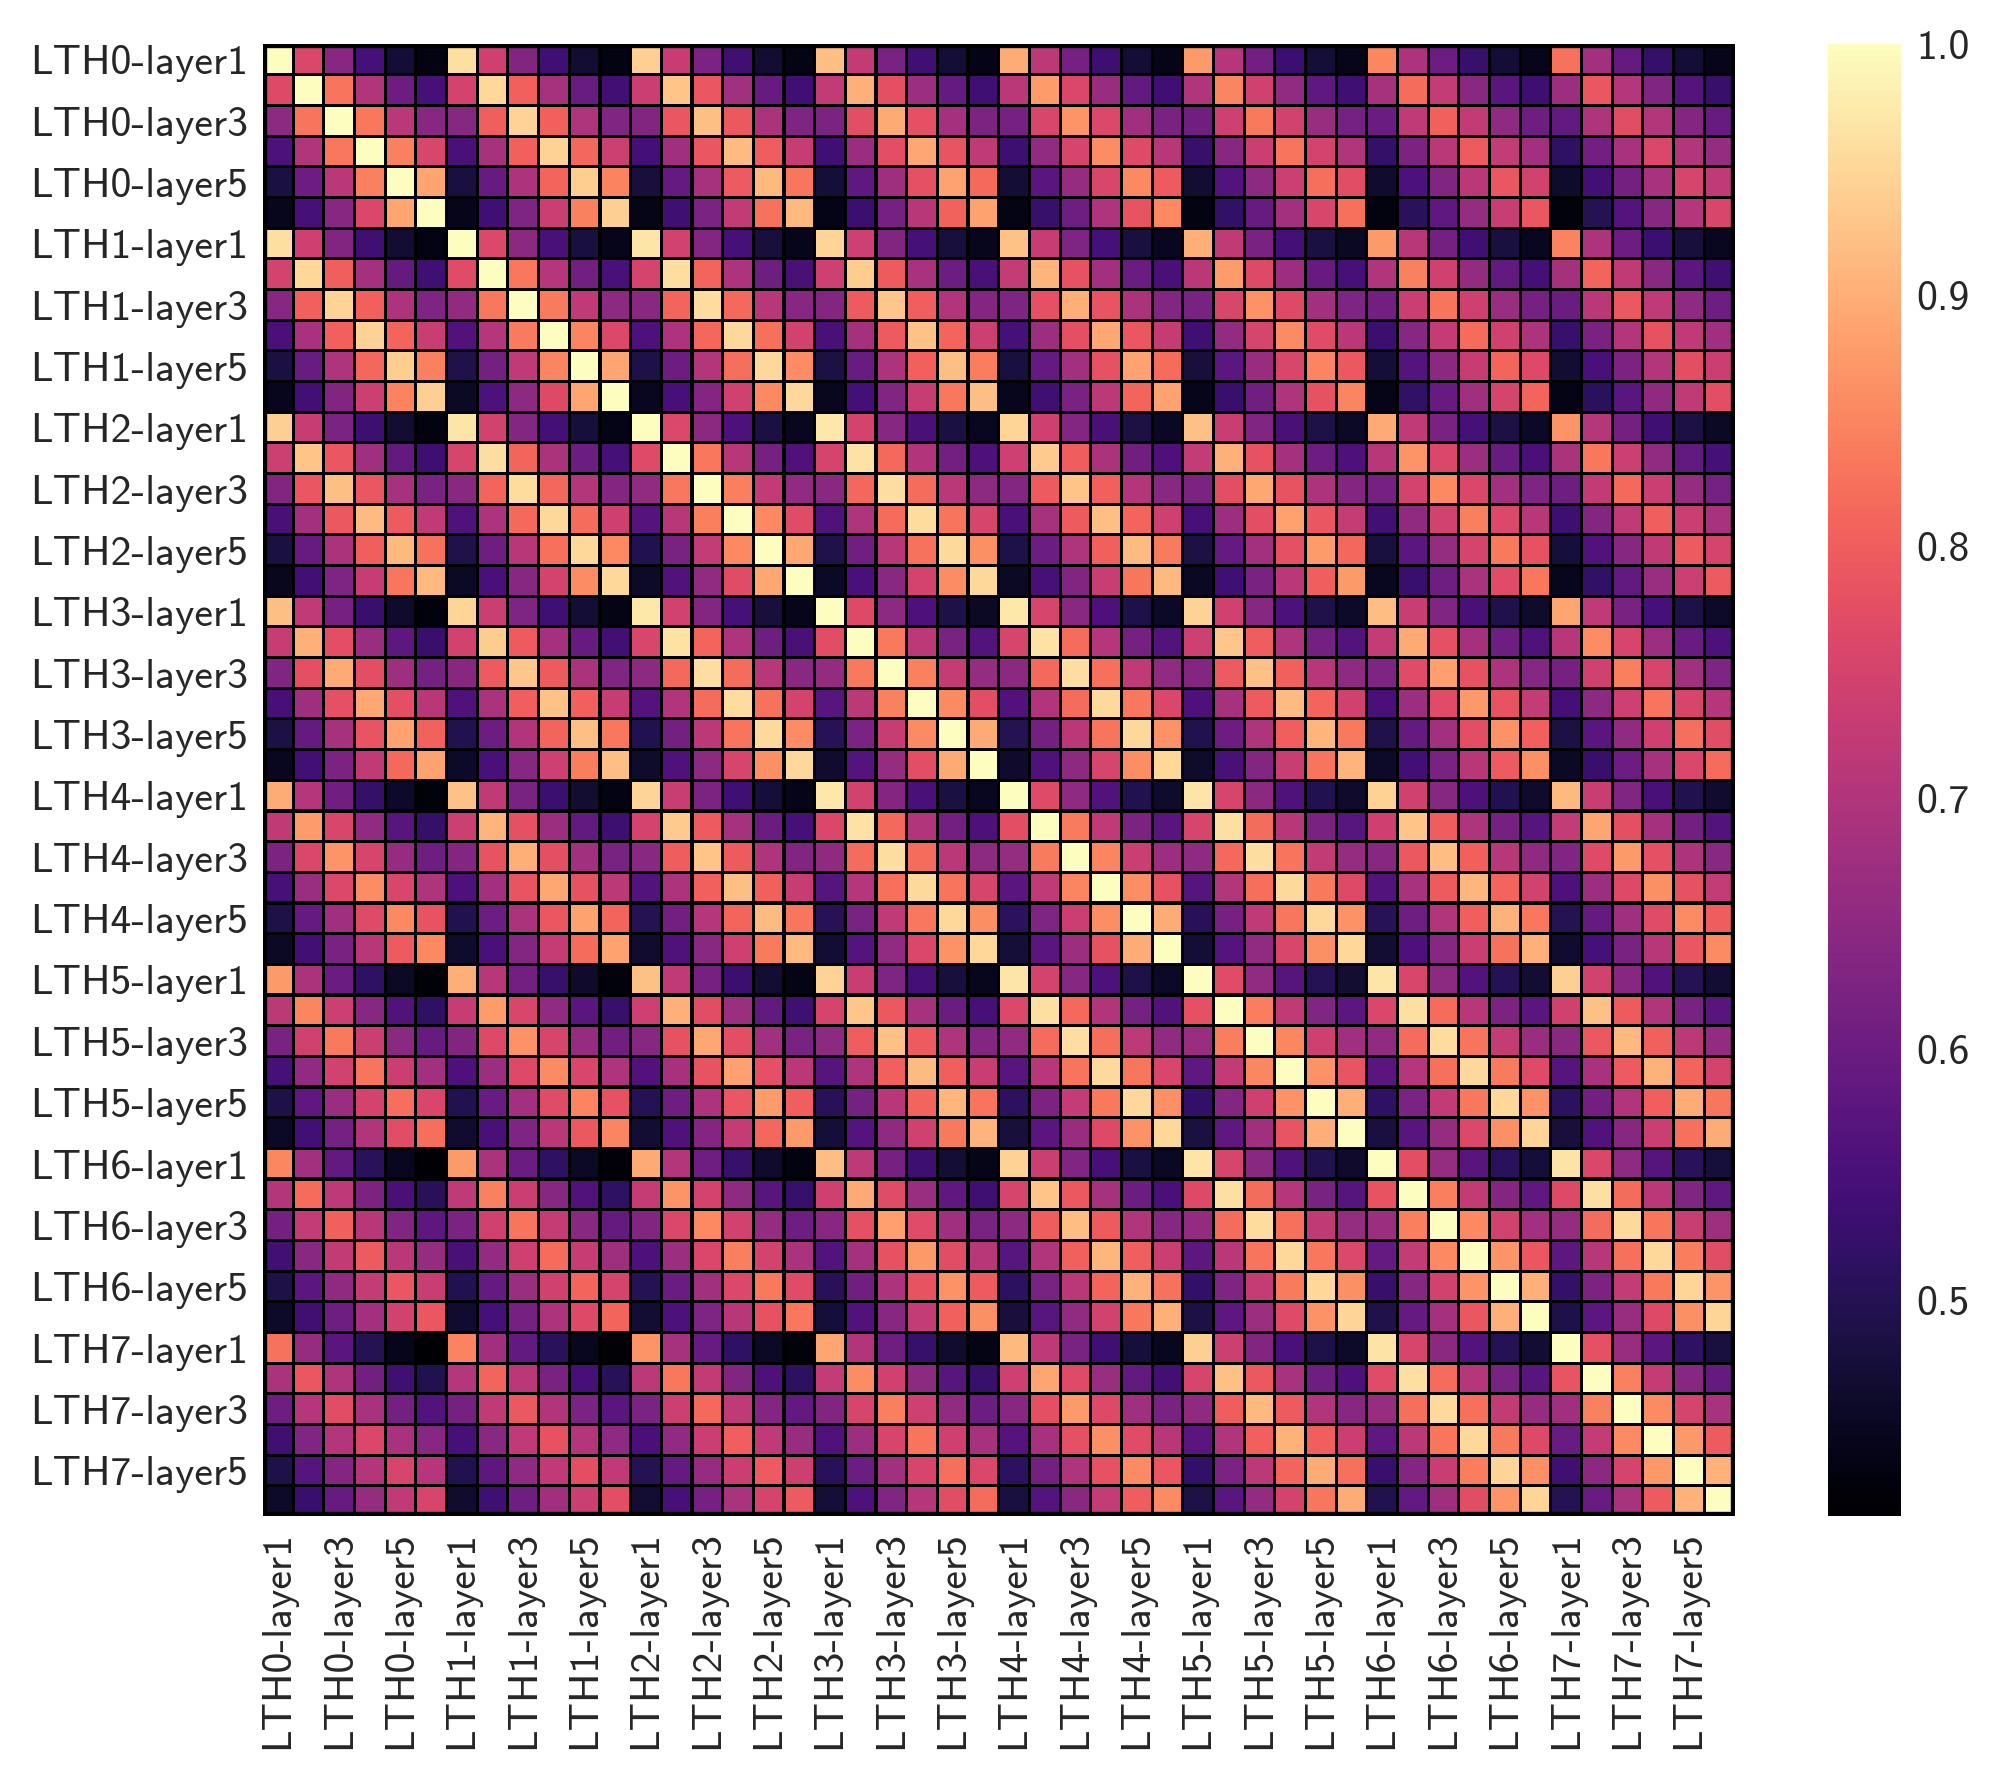

In [178]:
corr_df = pd.DataFrame(neuronsim['maxcorr'])

plt.figure(figsize = (8, 6.5), dpi=300)
ax = sns.heatmap(corr_df, cmap='magma', lw=0.5, linecolor='k', square=True)
ax.add_patch(Rectangle((0, 0), len(corr_df.columns), len(corr_df.index), fill=False, edgecolor='black', lw=2))
plt.show()

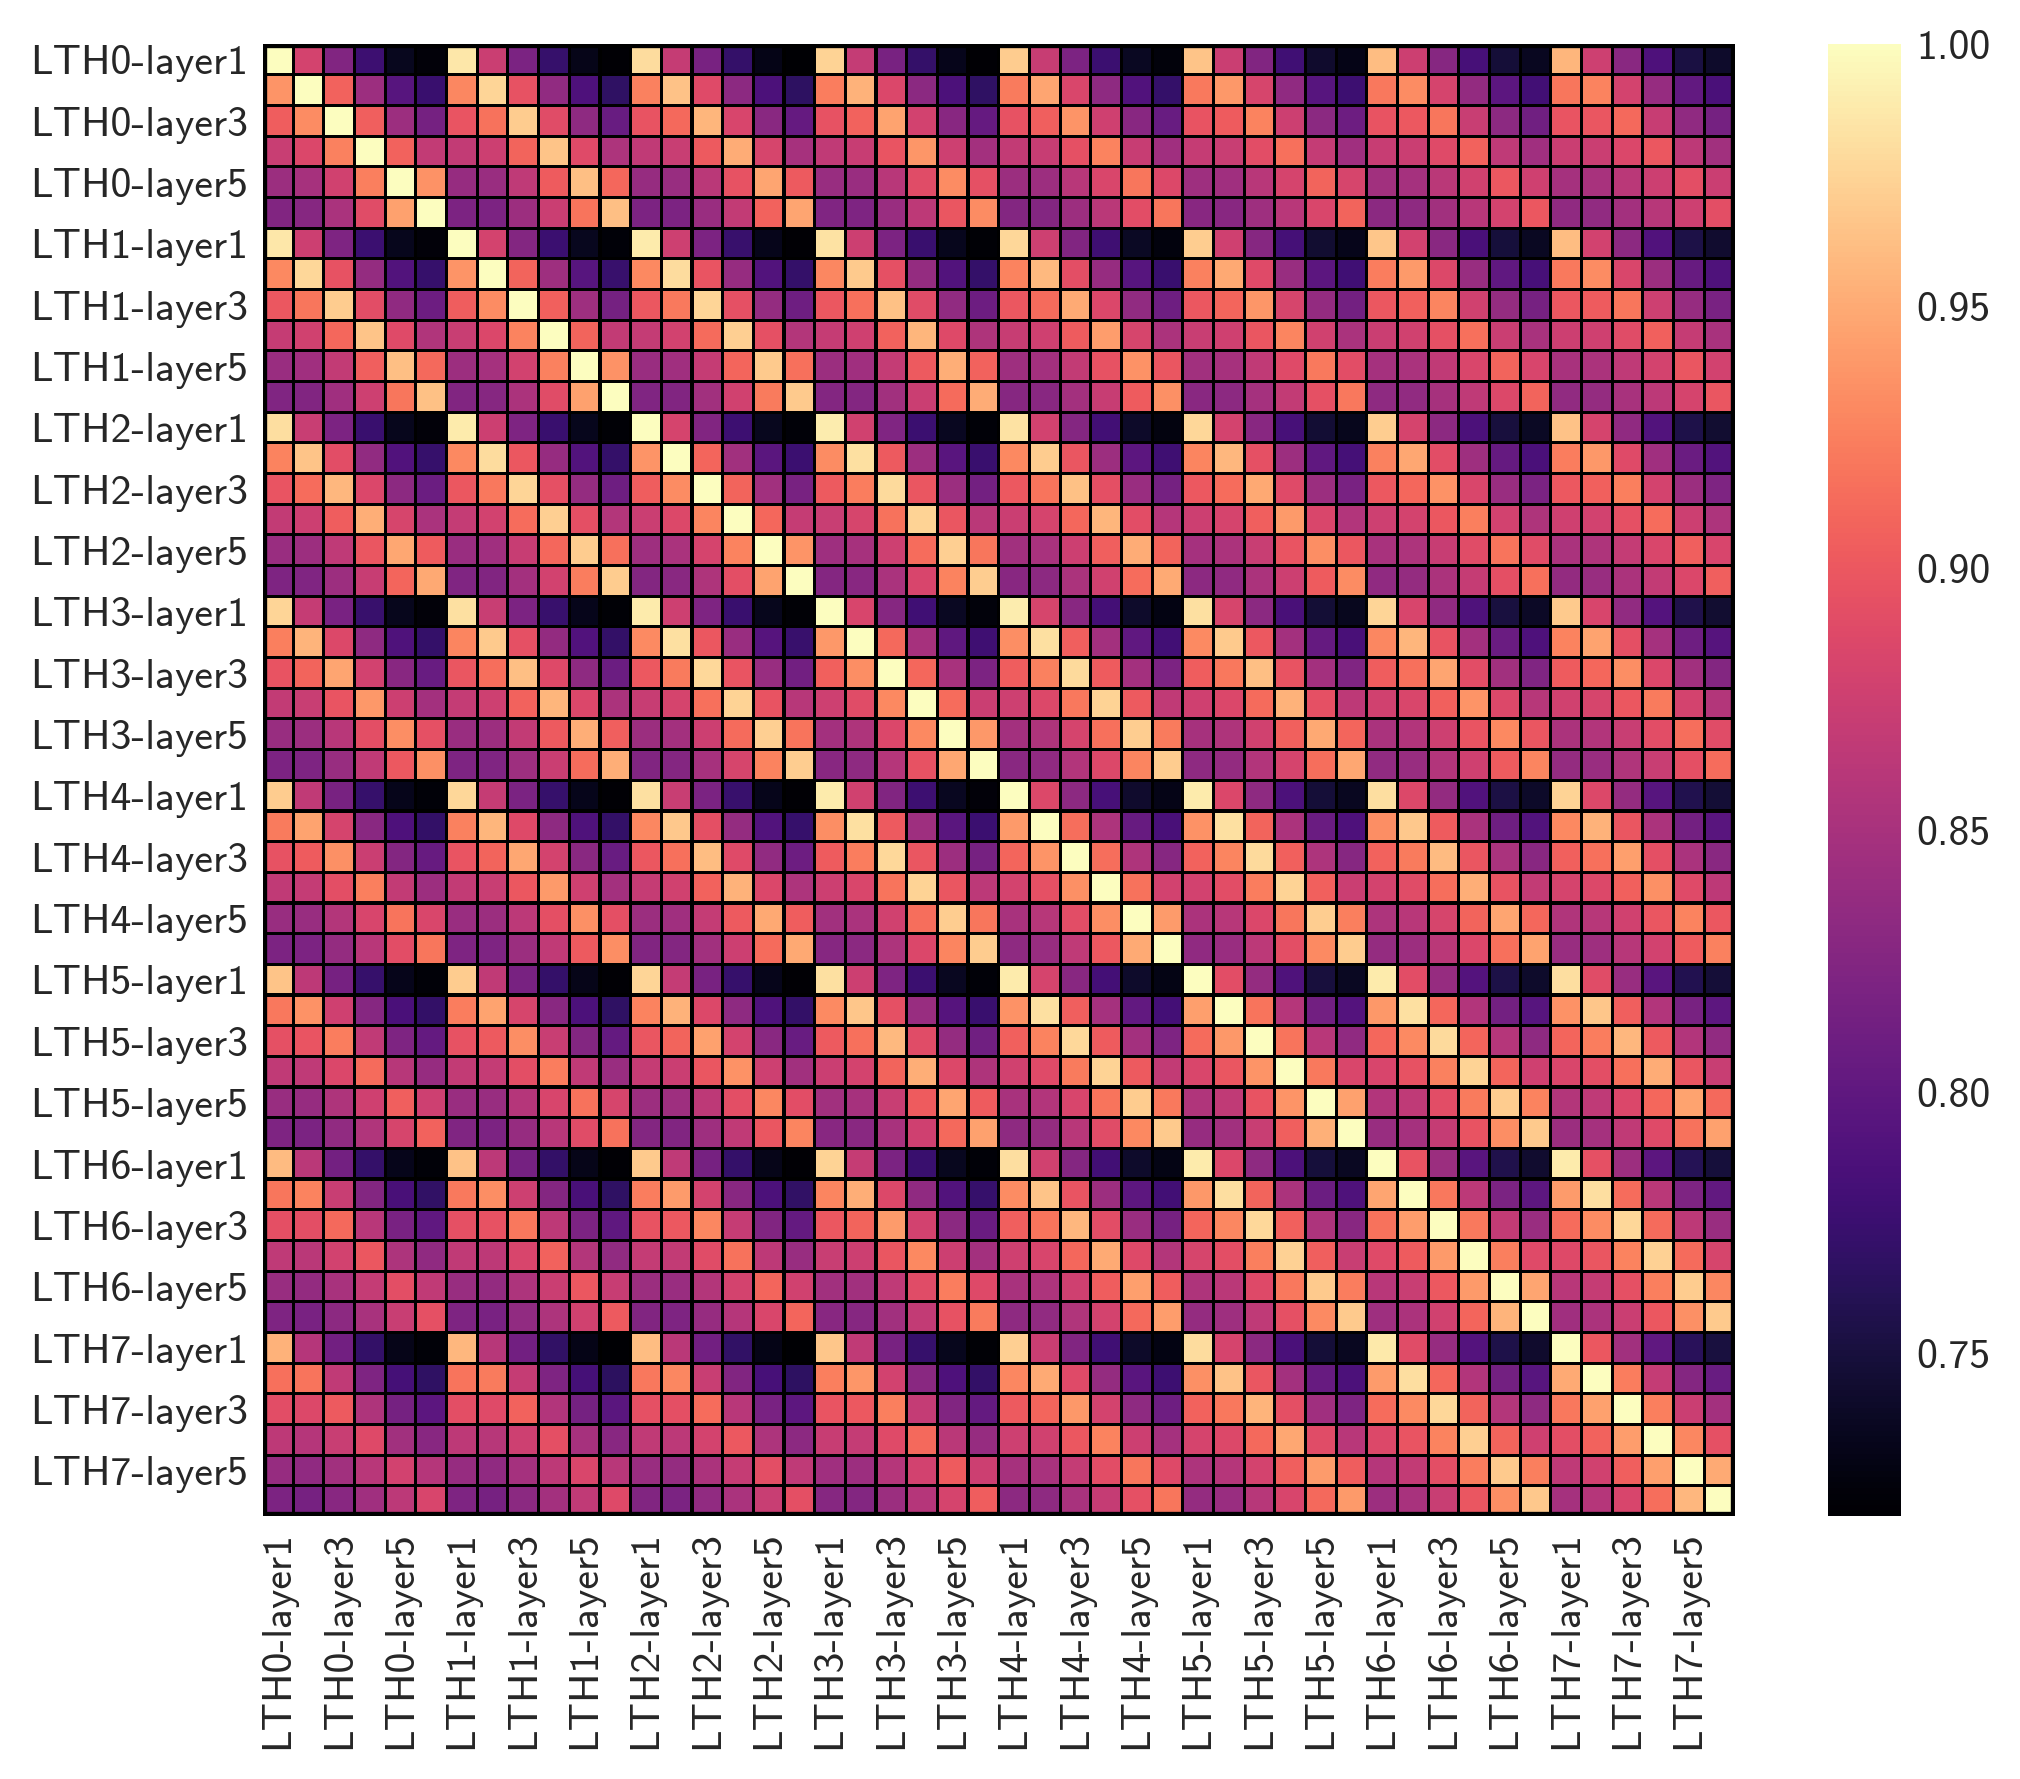

In [179]:
linreg_df = pd.DataFrame(neuronsim['maxlinreg'])

plt.figure(figsize = (8, 6.5), dpi=300)
ax = sns.heatmap(linreg_df, cmap='magma', lw=0.5, linecolor='k', square=True)
ax.add_patch(Rectangle((0, 0), len(linreg_df.columns), len(linreg_df.index), fill=False, edgecolor='black', lw=2))
plt.show()

In [145]:
layer_corrs_with_unpruned = {layer : [] for layer in ['layer' + str(i) for i in range(1, 7)]}
for layer in layer_corrs_with_unpruned:
    cur_layer = f'LTH0-{layer}'
    for lth_iter in range(model_count):
        layer_corrs_with_unpruned[layer].append(neuronsim['maxcorr'][cur_layer][f'LTH{lth_iter}-{layer}'])

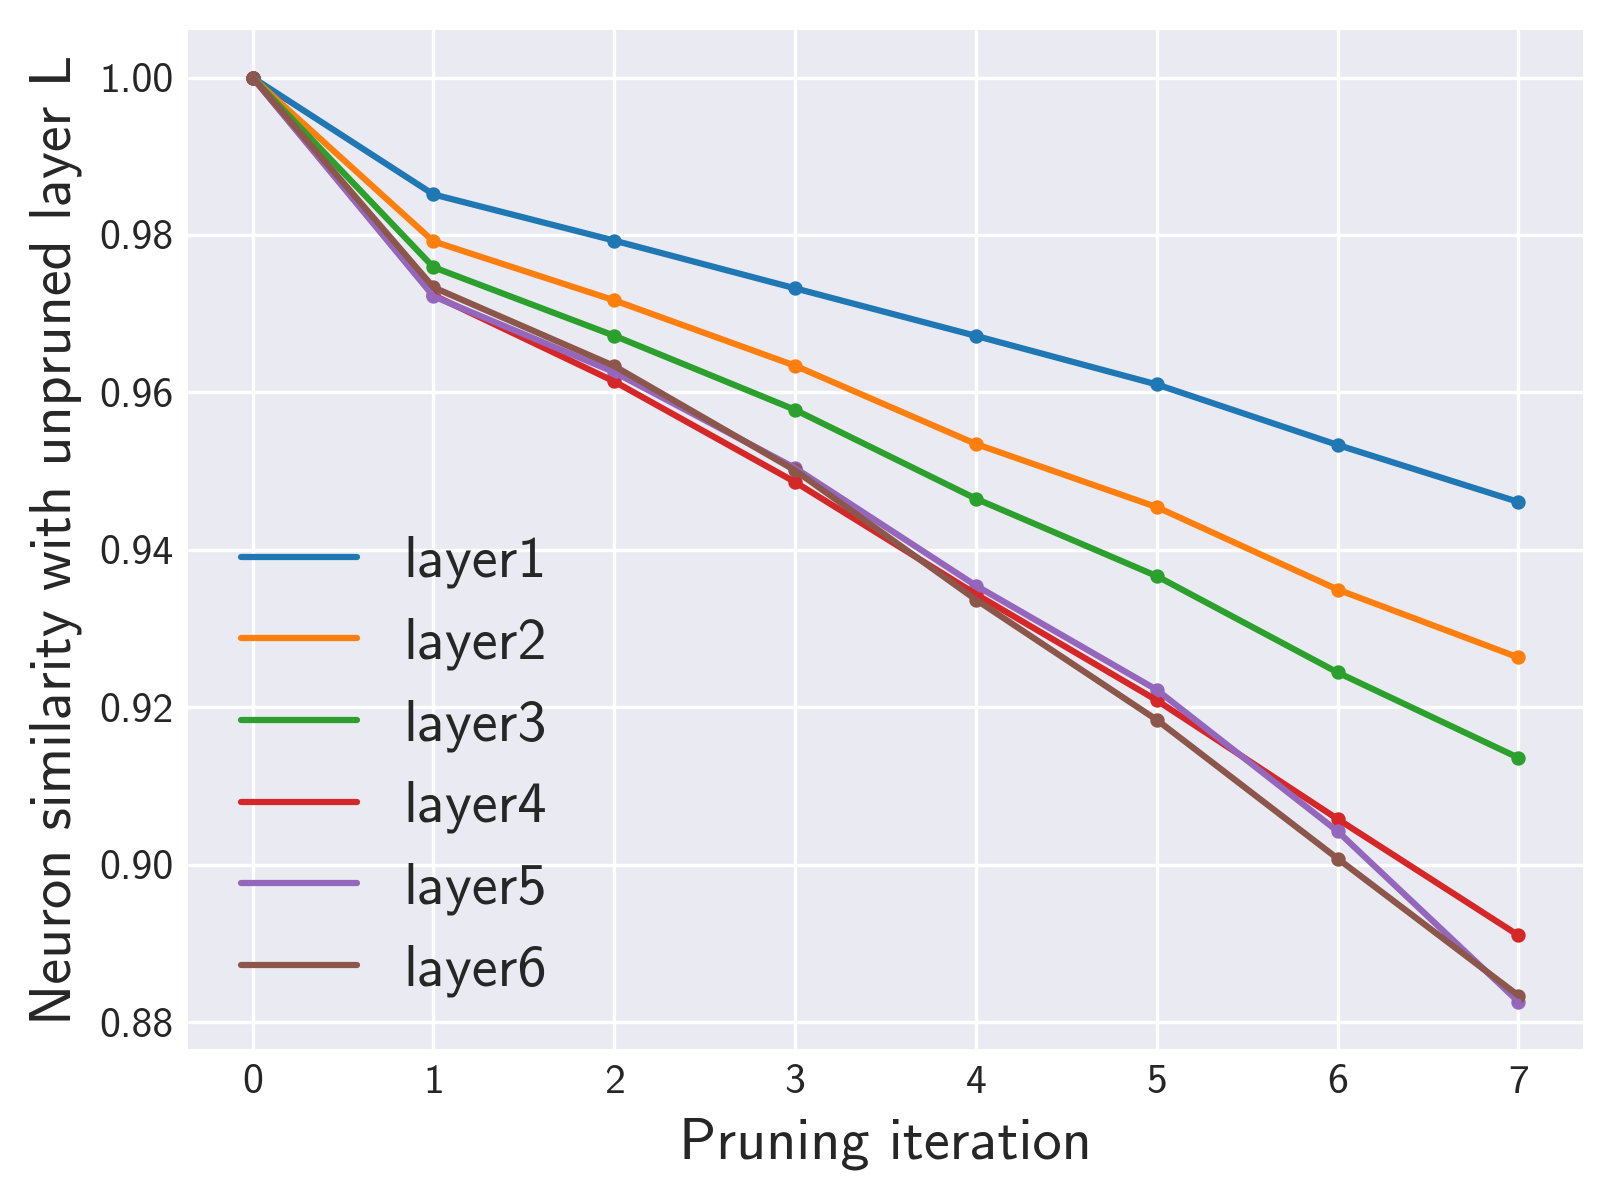

In [217]:
plt.figure(figsize = (6, 4.5), dpi=300)
ax = plt.gca()
x = range(model_count)

for layer in layer_corrs_with_unpruned:
    ax.plot(x, layer_corrs_with_unpruned[layer], label=layer)
    ax.scatter(x, layer_corrs_with_unpruned[layer], s=6)
    
plt.xlabel('Pruning iteration', fontsize=14)
plt.ylabel('Neuron similarity with unpruned layer L', fontsize=14)
plt.legend(fontsize=14)
plt.show()

We know that higher layers tend to be more model-specific. These results seem to further indicate that as sparsity increases, higher layers are even more model-specific.

## Analyze representation-level similarity between layers

In [169]:
res_dict["lincka"] = pickle.load(open(res_fname["lincka"], "rb"))

In [171]:
layersim = {'lincka' : {},
            }

def fix_layername(layer):
    return layer.split('-')[0] + '-layer' + str(int(layer.split('_')[-1])+1)

for simtype in layersim.keys():
    for layer in layer_names:
        layersim[simtype][fix_layername(layer)] = {fix_layername(layer) : 1.0}
        similarities = res_dict[simtype]['similarities'][layer]
        for other_layer in similarities:
            layersim[simtype][fix_layername(layer)][fix_layername(other_layer)] = similarities[other_layer]

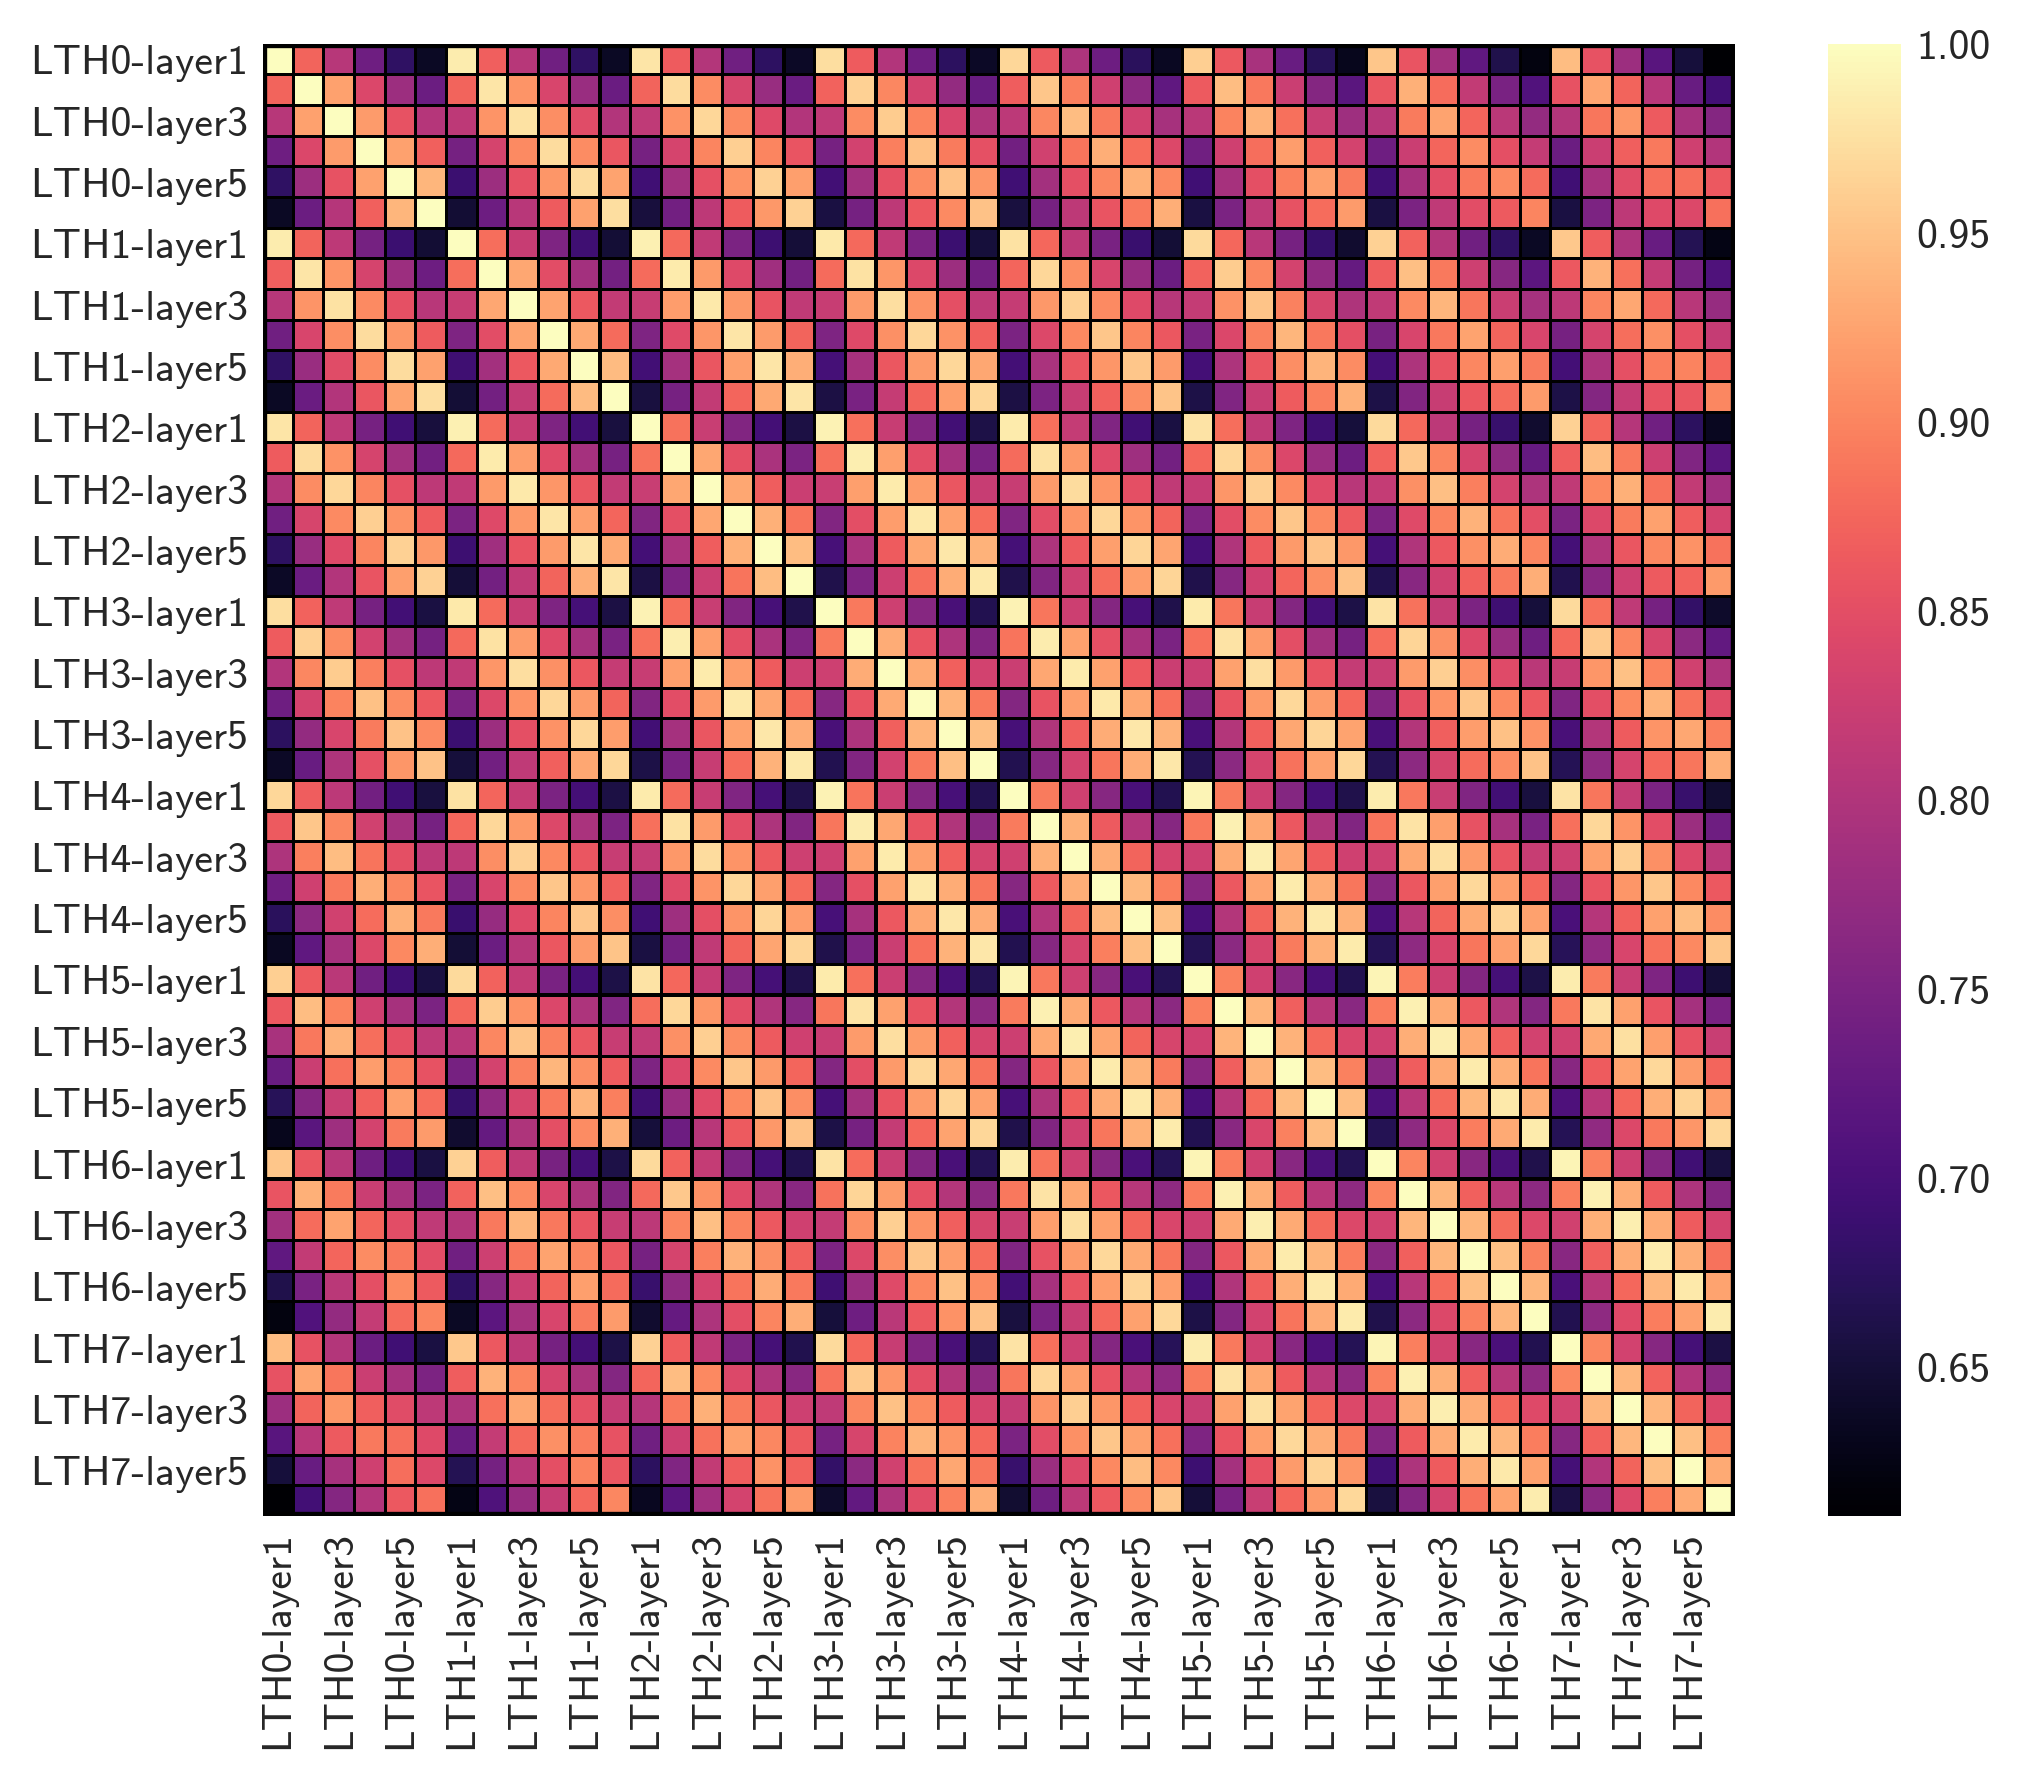

In [180]:
lincka_df = pd.DataFrame(layersim['lincka'])

plt.figure(figsize = (8, 6.5), dpi=300)
ax = sns.heatmap(lincka_df, cmap='magma', lw=0.5, linecolor='k', square=True)
ax.add_patch(Rectangle((0, 0), len(lincka_df.columns), len(lincka_df.index), fill=False, edgecolor='black', lw=2))
plt.show()

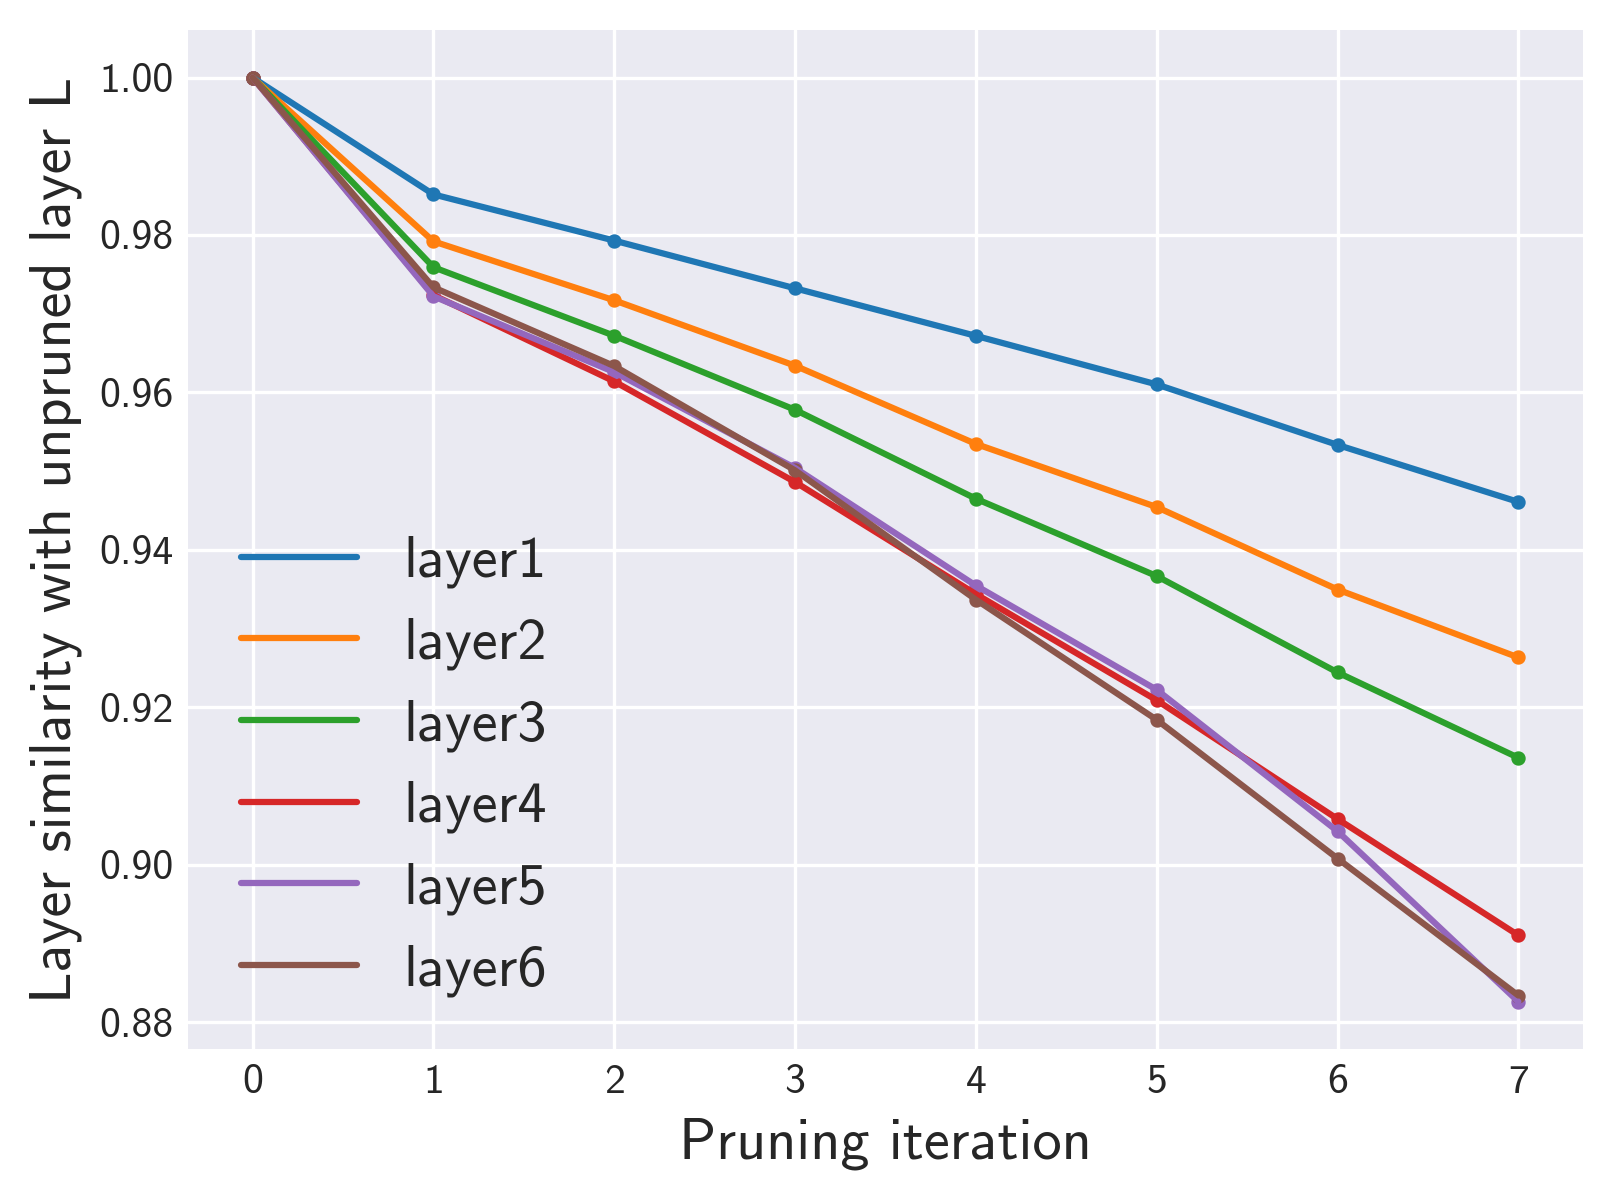

In [218]:
layer_corrs_with_unpruned = {layer : [] for layer in ['layer' + str(i) for i in range(1, 7)]}
for layer in layer_corrs_with_unpruned:
    cur_layer = f'LTH0-{layer}'
    for lth_iter in range(model_count):
        layer_corrs_with_unpruned[layer].append(layersim['lincka'][cur_layer][f'LTH{lth_iter}-{layer}'])
        
plt.figure(figsize = (6, 4.5), dpi=300)
ax = plt.gca()
x = range(model_count)

for layer in layer_corrs_with_unpruned:
    ax.plot(x, layer_corrs_with_unpruned[layer], label=layer)
    ax.scatter(x, layer_corrs_with_unpruned[layer], s=6)
    
plt.xlabel('Pruning iteration', fontsize=14)
plt.ylabel('Layer similarity with unpruned layer L', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [186]:
from scipy.stats import spearmanr

print(spearmanr(corr_df.values.flatten(), linreg_df.values.flatten()))
print(spearmanr(corr_df.values.flatten(), lincka_df.values.flatten()))
print(spearmanr(linreg_df.values.flatten(), lincka_df.values.flatten()))

SpearmanrResult(correlation=0.8918894955322911, pvalue=0.0)
SpearmanrResult(correlation=0.9889377466224094, pvalue=0.0)
SpearmanrResult(correlation=0.8853308058709471, pvalue=0.0)
